In [1]:
import sys
import os

app_base_dir = '/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import scipy.ndimage.filters
import scipy.signal
# import pandas as pd
# import pandas.io.sql as psql
# import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
# from tqdm import tqdm
# import glob
#import ROOT
import skimage
import skimage.filters
import skimage.restoration
import skimage.morphology

In [2]:
import supervised_classification as supc
import tool.acqconv

Welcome to JupyROOT 6.10/00


In [3]:
import matplotlib.colors 
import matplotlib.mlab as mlab

# Loading Data

In [4]:
con = pg.connect("dbname=eusospb_data user=eusospb password=1e20eVjemeuso host=localhost")
cur = con.cursor()

In [5]:
columns = ['event_id', 'packet_id', 'gtu_in_packet', 'num_gtu','source_file_acquisition_full']
#visible_showers = supervised_classification.select_training_data__visible_showers(cur, columns);
less34_visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(3, 4, 3, 800, 3), columns, limit=100000)[0]
visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=100000)[0]
invisible_showers = supc.select_training_data__invisible_showers(cur, columns)
low_energy_in_pmt = supc.select_training_data__low_energy_in_pmt(cur, columns) # maybe too many gtu
led = supc.select_training_data__led(cur, columns)

Executing query: 
SELECT 
          event_id,packet_id,gtu_in_packet,num_gtu,source_file_acquisition_full
        FROM spb_processing_event_ver2
        JOIN simu_event_spb_proc USING (event_id) 
        JOIN simu_event USING (simu_event_id) 
        JOIN simu_event_spb_proc_additional_info USING (relation_id) 
        WHERE 
        
         source_data_type_num = 3
         AND etruth_truetheta > 0.2618
         AND num_triggered_pixels BETWEEN 3 AND 800
         AND num_frames_signals_ge_bg BETWEEN 3 AND 4 
         
        ORDER BY num_triggered_pixels ASC, event_id ASC 
        OFFSET 0 LIMIT 100000
        ;
# Selected 1124 entries
Executing query: 
SELECT 
          event_id,packet_id,gtu_in_packet,num_gtu,source_file_acquisition_full
        FROM spb_processing_event_ver2
        JOIN simu_event_spb_proc USING (event_id) 
        JOIN simu_event USING (simu_event_id) 
        JOIN simu_event_spb_proc_additional_info USING (relation_id) 
        WHERE 
        
         source

In [6]:
visible_showers[0:20]

[(1011953,
  1,
  34,
  12,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.00e+13/thousnd21E20.2017-07-28-17h10m10s/npyconv/ev_9_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n4_m128.npy'),
 (1013574,
  1,
  36,
  12,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.70e+12/Ssegv18.2017-07-07-19h46m33s/npyconv/ev_96_mc_1__signals_p128_a0_g30_f128_b20170502-124722-001.001_k1_s0_d32_n16_m128.npy'),
 (1014843,
  1,
  44,
  10,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-20h06m01s/npyconv/ev_11_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n1_m128.npy'),
 (1015091,
  1,
  39,
  11,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-20h44m47s/npyconv/ev_80_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n17_m128.npy'),
 (1015291,
  1,
  38,
  9,
  '/home/eu

In [7]:
less34_visible_showers[0:20]

[(1009235,
  1,
  44,
  9,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.00e+13/sep21.2017-07-07-12h49m18s/npyconv/ev_10_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n6_m128.npy'),
 (1010487,
  1,
  40,
  9,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_24000000.00/energy_1.00e+13/para.2017-07-05-15h03m42s/npyconv/ev_86_mc_1__signals_p128_a0_g30_f128_b20170427-105115-001.001_k1_s0_d32_n45_m128.npy'),
 (1010514,
  1,
  47,
  10,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.00e+13/thousnd33E20.2017-07-26-15h00m07s/npyconv/ev_11_mc_1__signals_p128_a0_g30_f128_b20170429-080135-029.001_k1_s0_d32_n7_m128.npy'),
 (1010859,
  1,
  44,
  10,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_24000000.00/energy_1.00e+13/para.2017-07-05-15h31m14s/npyconv/ev_10_mc_1__signals_p128_a0_g30_f128_b20170427-105115-001.001_k1_s0_d32_n6_m128.npy'),
 (1012974,
  1,
  36,
  10,
  '/home/eusobg/EUSO-SPB/SPB

In [8]:
# save_npy_dir_pathname = '/mnt/miso_data2_4tb/nn_training_data/'
save_npy_dir_pathname = '/media/node15_data2/nn_training_data'

In [9]:
# re_acq_pathname = re.compile(r"^(.+)\/npyconv\/(ev_(\d+)_mc_1__signals).+$")

# num_visualized_entries = 20
# subplot_cols = 8
# subplot_rows = int(np.ceil((num_visualized_entries * 2 + 1) / subplot_cols))

def read_projections(all_rows, packet_simu_sequence_length = 35, packet_simu_data_gtu_offset = 30, max_entries=None, substract_bg=False, bgframes_length=30, bgframes_offset=0, apply_gaussian_filter=True, gaussian_filter_sigma=3):

    xy_projections = np.zeros((len(all_rows), 48, 48),dtype=np.float32)
    gtux_projections = np.zeros((len(all_rows), 48, packet_simu_sequence_length),dtype=np.float32)
    gtuy_projections = np.zeros((len(all_rows), 48, packet_simu_sequence_length),dtype=np.float32)

    for i, r in enumerate(all_rows):
        
        if max_entries is not None and max_entries >= 0 and i >= max_entries:
            break
            
        event_id, packet_id, gtu_in_packet, num_gtu, acquisition_file = r
        gtu_in_packet_corrected = max(gtu_in_packet - 4, 0)
        
        if gtu_in_packet_corrected + num_gtu < 30:
            print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
            continue
        
        if acquisition_file.endswith('.npy'):
            acquisition_arr = np.load(acquisition_file)[packet_id * 128:packet_id*128+128]
#             frames_acquisition = acquisition_arr[gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]                
        elif acquisition_file.endswith('.root'):
            acquisition_arr = tool.acqconv.get_frames(acquisition_file,
                                                         packet_id * 128 ,
                                                         packet_id * 128 + 127, 
                                                         entry_is_gtu_optimization=True)
        
        frames_acquisition = acquisition_arr[gtu_in_packet_corrected:gtu_in_packet_corrected + num_gtu]
        
        if substract_bg:
            avg_frames_background = np.add.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])/min(bgframes_length,len(acquisition_arr[bgframes_offset:]))
            if apply_gaussian_filter:
                avg_frames_background = scipy.ndimage.filters.gaussian_filter(avg_frames_background, gaussian_filter_sigma)
                        
            frames_acquisition = frames_acquisition.astype(np.float32)
            
            for frame in frames_acquisition:
                frame -= avg_frames_background

        xy_proj = np.maximum.reduce(frames_acquisition)
        
        gtuy_proj = []
        for frame in acquisition_arr[packet_simu_data_gtu_offset:packet_simu_data_gtu_offset+packet_simu_sequence_length]:
            gtuy_proj.append(np.max(frame, axis=1).reshape(-1, 1))  # max in the x axis
        gtuy_proj = np.hstack(gtuy_proj)

        gtux_proj = []
        for frame in acquisition_arr[packet_simu_data_gtu_offset:packet_simu_data_gtu_offset+packet_simu_sequence_length]:
            gtux_proj.append(np.max(frame, axis=0).reshape(-1, 1))  # max the y axis
        gtux_proj = np.hstack(gtux_proj)

        xy_projections[i] = xy_proj
        gtuy_projections[i] = gtuy_proj
        gtux_projections[i] = gtux_proj

    #     m = re_acq_pathname.search(acquisition_npy)
    #     if not m:
    #         print('Unexpected source_file_acquisition_full format "{}"'.format(acquisition_npy))
    #         continue
    #     signals_npy = os.path.join(m.group(1), "simu2npy", m.group(2) + ".npy")
    #     counts_npy = os.path.join(m.group(1), "simu2npy", 'ev_{:d}_mc_1__counts.npy'.format(m.group(3)))
    #     info_txt = os.path.join(m.group(1), "simu2npy", 'ev_{:d}_mc_1__info.txt'.format(m.group(3)))

    #     if not os.path.exists(acquisition_npy):
    #         raise Exception(
    #             'Acquisition file "{}" does not exists (#{})'.format(acquisition_npy, i))
    #     if not os.path.exists(signals_npy):
    #         raise Exception('Signals file "{}" does not exists (#{}  ID {})'.format(signals_npy, i))

            
    return xy_projections, gtux_projections, gtuy_projections

def save_projections(prefix, xy_projections, gtux_projections, gtuy_projections):
    os.makedirs(os.path.join(save_npy_dir_pathname,prefix),exist_ok=True)
    np.save(os.path.join(save_npy_dir_pathname,prefix,'xy_projections.npy'), xy_projections)
    np.save(os.path.join(save_npy_dir_pathname,prefix,'gtux_projections.npy'), gtux_projections)
    np.save(os.path.join(save_npy_dir_pathname,prefix,'gtuy_projections.npy'), gtuy_projections)


## Saving projections and then loading

In [10]:
save_projections('less34_visible_showers', *read_projections(less34_visible_showers, max_entries=100000))
# save_projections('visible_showers', *read_projections(visible_showers, max_entries=100000))
# save_projections('invisible_showers', *read_projections(invisible_showers, max_entries=100000))
# save_projections('low_energy_in_pmt', *read_projections(low_energy_in_pmt, max_entries=100000))
# save_projections('led', *read_projections(led, max_entries=100000))

In [11]:
# save_projections('visible_showers_bgsub_30gtu_sigma3', *read_projections(visible_showers, max_entries=100000, substract_bg=True))
# save_projections('invisible_showers_bgsub_30gtu_sigma3', *read_projections(invisible_showers, max_entries=100000, substract_bg=True))
# save_projections('low_energy_in_pmt_bgsub_30gtu_sigma3', *read_projections(low_energy_in_pmt, max_entries=100000, substract_bg=True))
# save_projections('led_bgsub_30gtu_sigma3', *read_projections(led, max_entries=100000, substract_bg=True))
# save_projections('visible_showers_bgsub_30gtu_nogauss', *read_projections(visible_showers, max_entries=10, substract_bg=True, apply_gaussian_filter=False))
# save_projections('invisible_showers_bgsub_30gtu_nogauss', *read_projections(invisible_showers, max_entries=10, substract_bg=True, apply_gaussian_filter=False))
# save_projections('low_energy_in_pmt_bgsub_30gtu_nogauss', *read_projections(low_energy_in_pmt, max_entries=10, substract_bg=True, apply_gaussian_filter=False))
# save_projections('led_bgsub_30gtu_nogauss', *read_projections(led, max_entries=10, substract_bg=True, apply_gaussian_filter=False))

In [12]:
gtux_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_sigma3','gtux_projections.npy'))
xy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_sigma3','xy_projections.npy'))
gtuy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_sigma3','gtuy_projections.npy'))
# gtux_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_nogauss','gtux_projections.npy'))
# xy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_nogauss','xy_projections.npy'))
# gtuy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_nogauss','gtuy_projections.npy'))

In [13]:
gtux_projections = np.load(os.path.join(save_npy_dir_pathname,'visible_showers','gtux_projections.npy'))
xy_projections = np.load(os.path.join(save_npy_dir_pathname,'visible_showers','xy_projections.npy'))
gtuy_projections = np.load(os.path.join(save_npy_dir_pathname,'visible_showers','gtuy_projections.npy'))

In [14]:
less34_gtux_projections = np.load(os.path.join(save_npy_dir_pathname,'less34_visible_showers','gtux_projections.npy'))
less34_xy_projections = np.load(os.path.join(save_npy_dir_pathname,'less34_visible_showers','xy_projections.npy'))
less34_gtuy_projections = np.load(os.path.join(save_npy_dir_pathname,'less34_visible_showers','gtuy_projections.npy'))

In [15]:
# # 
# q = '''
# SELECT 
# {columns}
# FROM spb_processing_event_ver2 
# WHERE 
# event_id IN (176709, 188415)
# ORDER BY
#   num_triggered_pixels DESC,
#   (trigg_x_y_hough__peak_thr1__max_cluster_counts_sum_width + trigg_gtu_x_hough__peak_thr1__max_cluster_counts_sum_width + trigg_gtu_y_hough__peak_thr1__max_cluster_counts_sum_width) ASC
# OFFSET {offset} LIMIT {limit}
# '''
# in_list_events = supc.select_events(cur, q, columns, limit=100000)[0]
# xy_projections_bgsub, gtux_projections_bgsub, gtuy_projections_bgsub = read_projections(in_list_events, max_entries=100000, substract_bg=True, apply_gaussian_filter=False)
# xy_projections, gtux_projections, gtuy_projections = read_projections(in_list_events, max_entries=100000, substract_bg=False)

## Background

In [16]:
# background_xy_projections = [None]*len(visible_showers)
# background_avg_xy_projections = [None]*len(visible_showers)

def get_background_projections(param_visible_showers, bgframes_offset = 0, bgframes_length = 32):
    background_xy_projections = [None]*len(param_visible_showers)
    background_avg_xy_projections = [None]*len(param_visible_showers)

    # visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=100000)[0]
    # supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=5000)[0]

    print(len(param_visible_showers))
    
    for i, r in enumerate(param_visible_showers):
        event_id, packet_id, gtu_in_packet, num_gtu, acquisition_file = r
        gtu_in_packet_corrected = max(gtu_in_packet - 4, 0)

        if gtu_in_packet_corrected + num_gtu < 30:
            print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
            continue

        if acquisition_file.endswith('.npy'):
            acquisition_arr = np.load(acquisition_file)[packet_id * 128:packet_id*128+128]
    #             frames_acquisition = acquisition_arr[gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]                
        elif acquisition_file.endswith('.root'):
            acquisition_arr = tool.acqconv.get_frames(acquisition_file,
                                                         packet_id * 128 ,
                                                         packet_id * 128 + 127, 
                                                         entry_is_gtu_optimization=True)

        frames_acquisition = acquisition_arr[gtu_in_packet_corrected:gtu_in_packet_corrected + num_gtu]

    #     if substract_bg:
        background_avg_xy_projections[i] = np.add.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])/min(bgframes_length,len(acquisition_arr[bgframes_offset:]))
        background_xy_projections[i] = np.maximum.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])

        if i % 500 == 0:
            print(i)

    return background_xy_projections, background_avg_xy_projections

In [17]:
# print( len(visible_showers) ,  len(less34_visible_showers) )

background_xy_projections, background_avg_xy_projections = get_background_projections(visible_showers)
less34_background_xy_projections, less34_background_avg_xy_projections = get_background_projections(less34_visible_showers)

4011
0
500
1000
1500
2000
2500
3000
3500
4000
1124
0
500
1000


In [18]:
less34_background_xy_projections[0].shape

(48, 48)

### Background distribution

mean
0.0


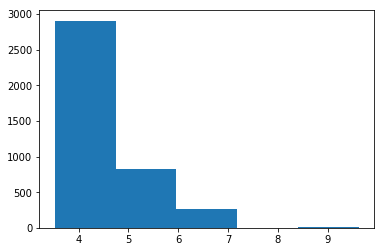

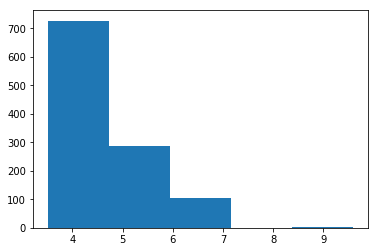

In [26]:
import scipy.optimize
def exp_func(x, a, c, d):
    return a*np.exp(-c*x)+d

print("mean")
mean_background_xy_pojections_averages = np.mean(np.array(background_xy_projections), axis=(1,2))
# plt.ylim(0,9000)
nvals, bins, patches = plt.hist(mean_background_xy_pojections_averages, log=False, bins=5)

print(np.count_nonzero(mean_background_xy_pojections_averages <= 3.5)/len(mean_background_xy_pojections_averages))
# print(mean_background_xy_pojections_averages)

# bins_shifted = np.array([(bins[ii]+bins[ii+1])/2 for ii in range(0,len(bins)-1)])
# popt, pcov =scipy.optimize.curve_fit(exp_func, bins_shifted, nvals, p0=(1, 1e-6, 1))
# perr = np.sqrt(np.diag(pcov))
# plt.plot(bins_shifted, exp_func(bins_shifted, *popt), 'r--')


plt.show()

# print( np.array(less34_background_xy_projections) )
mean_less34_background_xy_pojections_averages = np.mean(np.array(less34_background_xy_projections), axis=(1,2))
# print(mean_less34_background_xy_pojections_averages)
# # plt.ylim(0,9000)
n, bins, patches = plt.hist(mean_less34_background_xy_pojections_averages, log=False, bins=5)


# # plt.plot(bins_shifted, exp_func(bins_shifted, *[ 2.91e+04,   1.66e+00,  -2.72e+01]), 'g--')
# # plt.plot(bins_shifted, exp_func(bins_shifted, *[  2.90565383e+04 ,  1.66138652e+00 , -2.72290231e+01]), 'g--')
# print(popt, "\n---\n", pcov, "\n---\n", perr, "\n---\n", exp_func(bins_shifted, *popt))
# # print( exp_func(bins_shifted, *popt) )
# print(bins)

# plt.show()
# print("max")
# plt.hist(np.max(background_xy_projections, axis=(1,2)), log=False, bins=10)
plt.show()

## Simu signals

In [28]:
simu_xy_projections = [None]*len(visible_showers)

re_acq_pathname = re.compile(r"^(.+)\/npyconv\/(ev_(\d+)_mc_1__signals).+$")
# visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=100000)[0]
# supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=5000)[0]

for i, r in enumerate(visible_showers):
    event_id, packet_id, gtu_in_packet, num_gtu, acquisition_npy = r
    gtu_in_packet_corrected = gtu_in_packet - 4
    if gtu_in_packet_corrected + num_gtu < 30:
        print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
        continue
        
    m = re_acq_pathname.search(acquisition_npy)
    if not m:
        print('Unexpected source_file_acquisition_full format "{}"'.format(acquisition_npy))
        continue
    signals_npy = os.path.join(m.group(1), "simu2npy", m.group(2) + ".npy")

    if packet_id != 1:
        print('#{}  ID {}  packet_id != 1'.format(i, event_id))
        continue

    if not os.path.exists(acquisition_npy):
        raise Exception(
            'Acquisition file "{}" does not exists (#{}  ID {})'.format(acquisition_npy, i, event_id))
    if not os.path.exists(signals_npy):
        raise Exception('Signals file "{}" does not exists (#{}  ID {})'.format(signals_npy, i, event_id))

    signals_arr = np.load(signals_npy)
    acquisition_arr = np.load(acquisition_npy)

    if acquisition_arr.shape[0] != 256:
        raise Exception(
            'Unexpected number of frames in the acqusition file "{}" (#{}  ID {})'.format(acquisition_npy,
                                                                                          i, event_id))

    frames_acquisition = acquisition_arr[packet_id * 128 + gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]
#     frames_acquisition_signals = np.zeros_like(frames_acquisition)

    signals_start_gtu_in_pck = max(0, gtu_in_packet_corrected - 30)
    fas_start_gtu_in_pck = max(0, 30 - gtu_in_packet_corrected)

    if signals_start_gtu_in_pck > len(signals_arr):
        # print('#{}  ID {}  signals_start_gtu_in_pck > len(signals_arr)  ({} > {}, gtu_in_packet={})'.format(i, event_id, signals_start_gtu_in_pck, len(signals_arr), gtu_in_packet))
        continue

    if fas_start_gtu_in_pck > len(frames_acquisition):
        # should not happen
        raise Exception(
            '#{}  ID {}  fas_start_gtu_in_pck > len(signals_arr)  ({} > {}, gtu_in_packet={})'.format(i, event_id,
                                                                                                      fas_start_gtu_in_pck,
                                                                                                      len(frames_acquisition),
                                                                                                      gtu_in_packet_corrected))

    signals_end_gtu_in_pck = min(len(signals_arr),
                                 len(frames_acquisition) + signals_start_gtu_in_pck - fas_start_gtu_in_pck)
    fas_end_gtu_in_pck = min(len(signals_arr) + fas_start_gtu_in_pck - signals_start_gtu_in_pck,
                             len(frames_acquisition))

    signals_in_acquisition = signals_arr[signals_start_gtu_in_pck:signals_end_gtu_in_pck]
#     frames_acquisition_signals[fas_start_gtu_in_pck:fas_end_gtu_in_pck] = 
    simu_xy_projections[i] = np.add.reduce((signals_in_acquisition > 0) * frames_acquisition[fas_start_gtu_in_pck:fas_end_gtu_in_pck])

    if i % 500 == 0:
        print(i)


0
500
1000
1500
2000
2500
3000
3500
4000


## Signal to bg fractions

In [29]:
if len(background_xy_projections) != len(simu_xy_projections):
    raise Exception('invalid sizes')
signal_avg_to_bg_avg = np.zeros(len(simu_xy_projections))
for i, bg_proj in enumerate(background_xy_projections):
    simu_proj = simu_xy_projections[i]
    avg_bg = np.average(bg_proj[bg_proj > 0])
    avg_signal = np.average(simu_proj[simu_proj > 0])
    signal_avg_to_bg_avg[i] = (avg_signal/avg_bg) if avg_bg > 0 else np.inf

signal_avg_to_bg_avg

array([ 1.0876984 ,  1.11957754,  0.93998977, ...,  2.18713819,
        1.48147908,  2.14660225])

In [30]:
if len(background_xy_projections) != len(simu_xy_projections):
    raise Exception('invalid sizes')
signal_avg_over_mean_gz__to__bg_avg = np.zeros(len(simu_xy_projections))
for i, bg_proj in enumerate(background_xy_projections):
    simu_proj = simu_xy_projections[i]
    xy_proj_flatten = xy_projections[i].flatten()
    
#     bg_proj_flatten = bg_proj.flatten()
    simu_proj_flatten = simu_proj.flatten()
    signal_proj_over_meangz = xy_proj_flatten[simu_proj_flatten > np.mean(simu_proj_flatten[simu_proj_flatten > 0])] 
#     bg_proj_over_meangz = simu_proj_flatten[simu_proj_flatten > np.me an(simu_proj_flatten[simu_proj_flatten > 0])] 
    
    avg_bg = np.average(bg_proj[bg_proj > 0])
    avg_signal = np.average(simu_proj[simu_proj > 0]) #np.average(simu_proj_over_meangz) # 
    signal_avg_over_mean_gz__to__bg_avg[i] = (avg_signal/avg_bg) if avg_bg > 0 else np.inf

signal_avg_over_mean_gz__to__bg_avg

array([ 1.0876984 ,  1.11957754,  0.93998977, ...,  2.18713819,
        1.48147908,  2.14660225])

In [31]:
if len(background_xy_projections) != len(simu_xy_projections):
    raise Exception('invalid sizes')
signal_avg_50perc_gz__to__bg_avg = np.zeros(len(simu_xy_projections))
for i, bg_proj in enumerate(background_xy_projections):
    simu_proj = simu_xy_projections[i]
    xy_proj_flatten = xy_projections[i].flatten()
    
    
    
#     bg_proj_flatten = bg_proj.flatten()
    simu_proj_flatten = simu_proj.flatten()
    simu_proj_flatten_gz = simu_proj_flatten[simu_proj_flatten > 0]
    # xy_proj_flatten is intentionally here
    simu_proj_max_50prec = xy_proj_flatten[ np.argpartition(simu_proj_flatten_gz, -len(simu_proj_flatten_gz)//2)[-len(simu_proj_flatten_gz)//2:] ]  
    
    
#     signal_proj_over_meangz = xy_proj_flatten[simu_proj_flatten > np.mean(simu_proj_flatten[simu_proj_flatten > 0])] 
#     bg_proj_over_meangz = simu_proj_flatten[simu_proj_flatten > np.me an(simu_proj_flatten[simu_proj_flatten > 0])] 
    
    avg_bg = np.average(bg_proj[bg_proj > 0])
    avg_signal = np.average(simu_proj_max_50prec) # np.average(simu_proj[simu_proj > 0]) #np.average(simu_proj_over_meangz) # 
    signal_avg_50perc_gz__to__bg_avg[i] = (avg_signal/avg_bg) if avg_bg > 0 else np.inf
    if signal_avg_50perc_gz__to__bg_avg[i] > 5:
        print(i, signal_avg_50perc_gz__to__bg_avg[i])

signal_avg_50perc_gz__to__bg_avg

array([ 0.78114798,  0.8511857 ,  0.71398133, ...,  0.83746701,
        0.90637712,  0.82331611])

In [32]:
if len(background_xy_projections) != len(simu_xy_projections):
    raise Exception('invalid sizes')
signal_avg_50perc_gz__to__bg_avg_50perc_gz = np.zeros(len(simu_xy_projections))
for i, bg_proj in enumerate(background_xy_projections):
    simu_proj = simu_xy_projections[i]
    xy_proj_flatten = xy_projections[i].flatten()
    
#     bg_proj_flatten = bg_proj.flatten()
    simu_proj_flatten = simu_proj.flatten()
    simu_proj_flatten_gz = simu_proj_flatten[simu_proj_flatten > 0]
    # xy_proj_flatten is intentionally here
    simu_proj_max_50prec = xy_proj_flatten[ np.argpartition(simu_proj_flatten_gz, -len(simu_proj_flatten_gz)//2)[-len(simu_proj_flatten_gz)//2:] ] 
    
    
    bg_proj_flatten = bg_proj.flatten()
    bg_proj_flatten_gz = bg_proj_flatten[bg_proj_flatten > 0]
    # xy_proj_flatten is intentionally here
    bg_proj_max_50prec = xy_proj_flatten[ np.argpartition(bg_proj_flatten_gz, -len(bg_proj_flatten_gz)//2)[-len(bg_proj_flatten_gz)//2:] ] 
    
#     signal_proj_over_meangz = xy_proj_flatten[simu_proj_flatten > np.mean(simu_proj_flatten[simu_proj_flatten > 0])] 
#     bg_proj_over_meangz = simu_proj_flatten[simu_proj_flatten > np.me an(simu_proj_flatten[simu_proj_flatten > 0])] 
    
    avg_bg = np.average(bg_proj_max_50prec) # np.average(bg_proj[bg_proj > 0])
    avg_signal = np.average(simu_proj_max_50prec) # np.average(simu_proj[simu_proj > 0]) #np.average(simu_proj_over_meangz) # 
    signal_avg_50perc_gz__to__bg_avg_50perc_gz[i] = (avg_signal/avg_bg) if avg_bg > 0 else np.inf
    if signal_avg_50perc_gz__to__bg_avg_50perc_gz[i] > 5:
        print(i, signal_avg_50perc_gz__to__bg_avg_50perc_gz[i])

signal_avg_50perc_gz__to__bg_avg_50perc_gz

array([ 0.78114798,  0.8511857 ,  0.71398133, ...,  0.83746701,
        0.90637712,  0.82331611])

In [33]:
signal_avg_50perc_gz__to__bg_avg_50perc_gz[10]

1.12689208984375

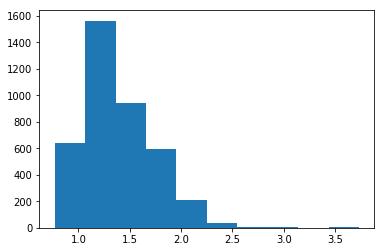

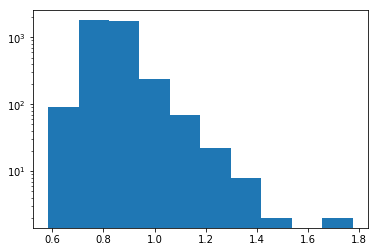

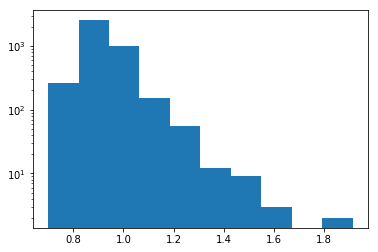

In [34]:

# # signal_avg_over_mean_gz__to__bg_avg[10]
# # visible_showers[10]
# # print(simu_proj_flatten[ np.argpartition(simu_proj_flatten, -4)[-4:] ] )
# # simu_proj_flatten[simu_proj_flatten > np.mean(simu_proj_flatten[simu_proj_flatten > 0])] 
# # plt.hist(simu_proj_flatten[simu_proj_flatten > 0])
plt.hist(signal_avg_over_mean_gz__to__bg_avg)
plt.show()
plt.hist(signal_avg_50perc_gz__to__bg_avg,log=True)
plt.show()
plt.hist(signal_avg_50perc_gz__to__bg_avg_50perc_gz, log=True)
plt.show()

# # plt.imshow(xy_projections[10] - background_xy_projections[10])
# plt.imshow(xy_projections[2753])
# plt.show()

# Single event experiments

In [161]:
n = 1000 # 10 # 10 #4000 # 5 # 

In [162]:
avg_frames_background = background_avg_xy_projections[n]

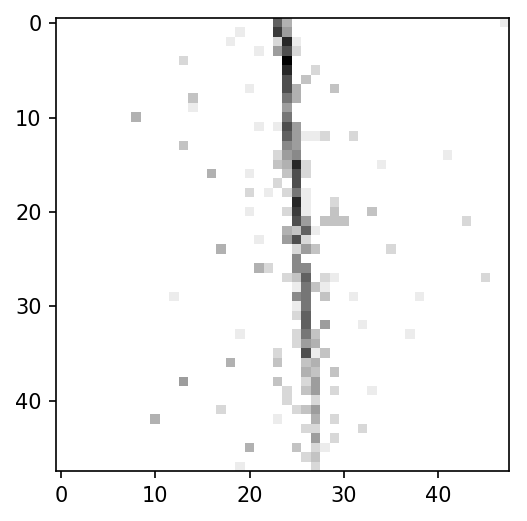

In [163]:
mpl.rcParams['figure.dpi'] = 150
plt.imshow(simu_xy_projections[n], cmap='binary')
plt.show()

## loading background for the single event

In [164]:
mpl.rcParams['figure.dpi'] = 80

base_xy_proj = xy_projections_bgsub[n] * (xy_projections_bgsub[n]>0)
print("mean",  base_xy_proj.mean())
base_xy_proj_cent = (base_xy_proj - base_xy_proj.mean() )
print('max(abs(cent))', np.max(np.abs(base_xy_proj_cent)))
base_xy_proj_max_norm = base_xy_proj_cent/np.max(np.abs(base_xy_proj_cent))
base_xy_proj_std_norm = base_xy_proj_cent/np.std(base_xy_proj_cent)
# print(base_xy_proj_max_norm)
# big number of experiments have been removed from here

base_xy_proj_w_bg = xy_projections[n] * (xy_projections[n]>0)
base_xy_proj_w_bg_cent = (base_xy_proj_w_bg - base_xy_proj_w_bg.mean() )
base_xy_proj_w_bg_max_norm = base_xy_proj_w_bg_cent/np.max(np.abs(base_xy_proj_w_bg_cent))

print("base_xy_proj_w_bg.mean()",  base_xy_proj_w_bg.mean())
print('max(abs(base_xy_proj_w_bg_cent))', np.max(np.abs(base_xy_proj_w_bg_cent)))

base_xy_proj_n_bg = xy_projections[n] - avg_frames_background
base_xy_proj_n_bg *= (base_xy_proj_n_bg > 0)
base_xy_proj_n_bg_cent = (base_xy_proj_n_bg - base_xy_proj_n_bg.mean() )
base_xy_proj_n_bg_max_norm = base_xy_proj_n_bg_cent/np.max(np.abs(base_xy_proj_n_bg_cent))

print("base_xy_proj_n_bg.mean()",  base_xy_proj_n_bg.mean())
print('max(abs(base_xy_proj_n_bg_cent))', np.max(np.abs(base_xy_proj_n_bg_cent)))



mean 2.11368
max(abs(cent)) 9.91527
base_xy_proj_w_bg.mean() 3.22135
max(abs(base_xy_proj_w_bg_cent)) 9.77865
base_xy_proj_n_bg.mean() 2.10579427083
max(abs(base_xy_proj_n_bg_cent)) 9.86295572917


In [165]:
# this was added from later
xy_proj = xy_projections[n]
xy_proj_subabg = xy_projections[n] - avg_frames_background
xy_proj_subabg *= (xy_proj_subabg > 0)


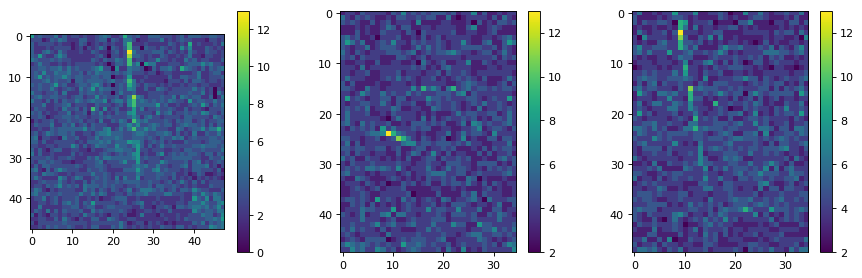

In [166]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(20/1.5,6/1.5)
axs_flattened = axs.flatten()
cax = axs_flattened[0].imshow(xy_projections[n])
fig.colorbar(cax, ax=axs_flattened[0])
cax = axs_flattened[1].imshow(gtux_projections[n])
fig.colorbar(cax, ax=axs_flattened[1])
cax = axs_flattened[2].imshow(gtuy_projections[n])
fig.colorbar(cax, ax=axs_flattened[2])
plt.show()

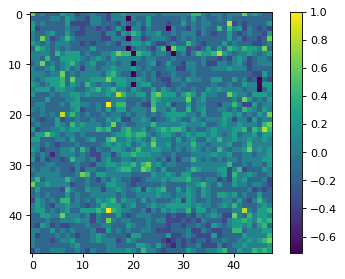

In [167]:
bg_xy_proj = background_xy_projections[n] #np.maximum.reduce(frames_background)
bg_xy_proj_cent = bg_xy_proj - np.mean(bg_xy_proj)
bg_xy_proj_cent_max_norm = bg_xy_proj_cent/np.max(np.abs(bg_xy_proj_cent))
bg_xy_proj_cent_std_norm = bg_xy_proj_cent/np.std(bg_xy_proj_cent)
mpl.rcParams['figure.dpi'] = 80
cax = plt.imshow(bg_xy_proj_cent_max_norm)
plt.colorbar(cax)
plt.show()

# Counts distribution

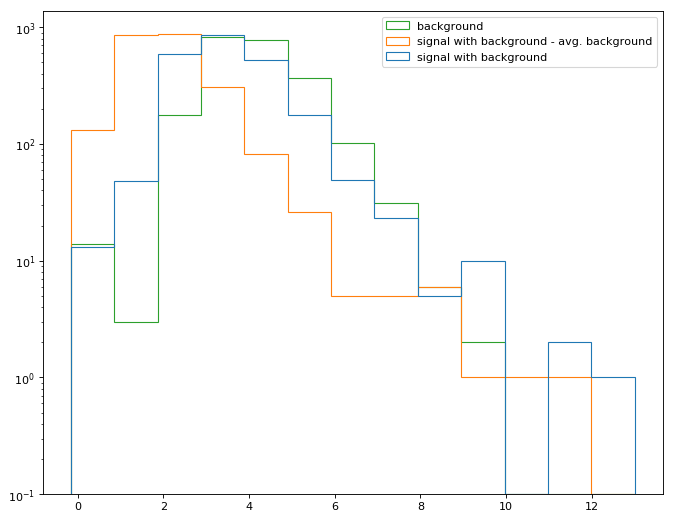

In [168]:
mpl.rcParams['figure.dpi'] = 80
fig, ax = plt.subplots(1)
# ax.hist(xy_projections[n].flatten(), bins=13, log=True)
# fig, ax = plt.subplots(1)
# ax.hist((xy_projections[n] - avg_frames_background).flatten(), bins=12, log=True)
# fig, ax = plt.subplots(1)
# ax.hist(background_xy_projections[n].flatten(), bins=9, log=True)
fig.set_size_inches(10,8)
ax.hist( np.transpose(np.vstack([xy_projections[n].flatten(), (xy_projections[n] - avg_frames_background).flatten() , 
                                background_xy_projections[n].flatten()
#                                  np.maximum.reduce(npy_clear_background).flatten()
                                ])), 
 13, stacked=False, histtype='step', # , histtype='bar',  #fill=False,
        log=True, label=['signal with background', 'signal with background - avg. background', 'background'])
ax.legend(prop={'size': 10})
plt.show()

# Statistics for all events

# Gabor wavelet classification

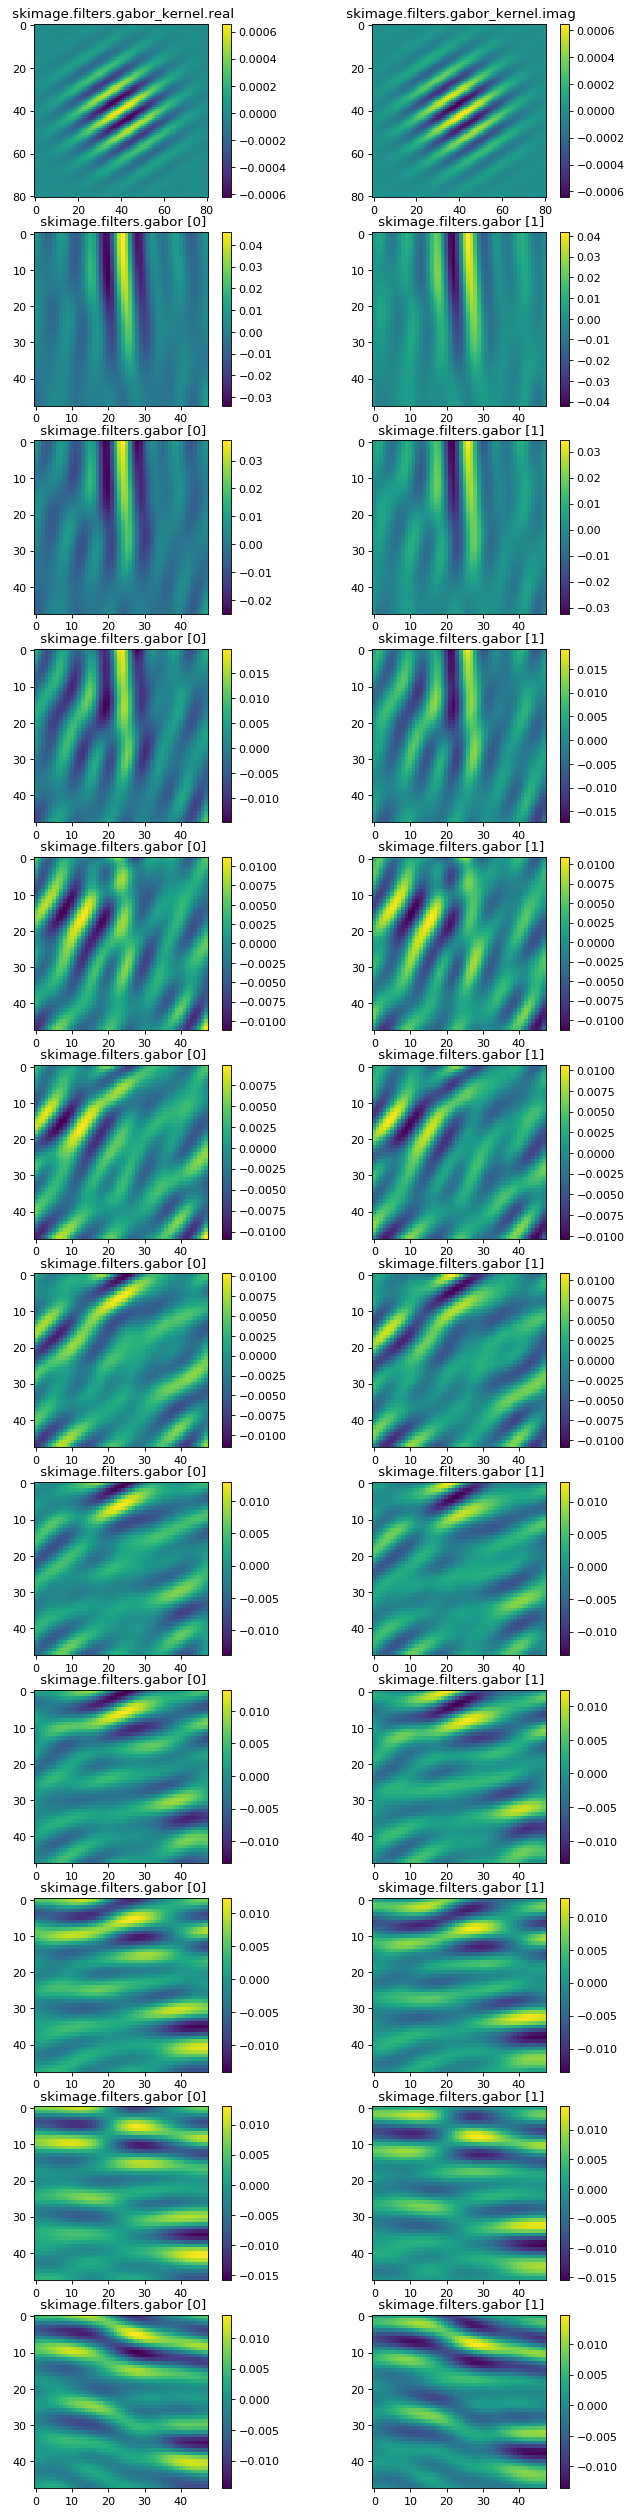

In [169]:
plt.close('all')
cols=2
rows=12
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0

# import skimage.data    
freq = 0.1
band = 1
sigma_x = None
sigma_y = None

mpl.rcParams['figure.dpi'] = 80

cax = axs_flattened[i].imshow( skimage.filters.gabor_kernel(freq, band, np.deg2rad(20), sigma_x, sigma_y).real )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor_kernel.real') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.gabor_kernel(freq, band, np.deg2rad(20), sigma_x, sigma_y).imag )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor_kernel.imag') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

gabor_input = base_xy_proj_n_bg_max_norm
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(0), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1               
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(10), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  

base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(20), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(30), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(40), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(50), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(60), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1        
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(70), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1    
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(80), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                     
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(90), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                        
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(100), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1   
# cax = axs_flattened[i].imshow( skimage.filters.gabor(base_xy_proj_n_bg_max_norm, 0.6) )
# axs_flattened[i].set_title('skimage.filters.gabor n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

# base_xy_proj_w_bg_max_norm_positive = base_xy_proj_w_bg_max_norm-np.min(base_xy_proj_w_bg_max_norm)
# base_xy_proj_w_bg_max_norm_positive /= np.max(base_xy_proj_w_bg_max_norm_positive)

# base_xy_proj_n_bg_max_norm_positive = base_xy_proj_n_bg_max_norm-np.min(base_xy_proj_n_bg_max_norm)
# base_xy_proj_n_bg_max_norm_positive /= np.max(base_xy_proj_n_bg_max_norm_positive)

# cax = axs_flattened[i].imshow( skimage.restoration.denoise_bilateral(base_xy_proj_w_bg_max_norm_positive, multichannel=False) ) 
# axs_flattened[i].set_title('skimage.restoration.denoise_bilateral w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_bilateral(base_xy_proj_n_bg_max_norm_positive, multichannel=False) )
# axs_flattened[i].set_title('skimage.restoration.denoise_bilateral n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_w_bg_max_norm, multichannel=False) ) 
# axs_flattened[i].set_title('skimage.restoration.denoise_wavelet w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_n_bg_max_norm, multichannel=False) )
# axs_flattened[i].set_title('skimage.restoration.denoise_wavelet n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

plt.show()

In [170]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = scipy.ndimage.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


def vis_match(feats, ref_feats):
    cols = 4
    rows = int(np.ceil(len(feats)/cols))
#     fig, axs = plt.subplots(rows, cols)
#     axs_flattened = axs.flatten()
#     fig.set_size_inches(cols*5.5,rows*4*0.85)
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        title = "e: {:.5f}".format(error)
        if error < min_error:
            min_error = error
            min_i = i
            title += " | m"
        
        print(i, title)
#         axs_flattened[k].imshow( (feats - ref_feats[i, :])**2 )
#         axs_flattened[k].set_title(title)
        
    return min_i

def vis_feats(image, kernels, kernel_labels=[]):
    cols = 4
    rows = int(np.ceil(len(kernels)/cols))
    fig, axs = plt.subplots(rows, cols)
    fig.set_size_inches(cols*5.5,rows*4*0.85)
    axs_flattened = axs.flatten()
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = scipy.ndimage.convolve(image, kernel, mode='wrap')
#         feats[k, 0] = filtered.mean()
#         feats[k, 1] = filtered.var()
        axs_flattened[k].imshow(filtered)
        title = "m: {:.5f} v: {:.5f}".format(filtered.mean(), filtered.var())
        if k < len(kernel_labels):
            title += " | t: {:.3f} s: {:.3f} f: {:.3f}".format(*kernel_labels[k])
        axs_flattened[k].set_title(title)
    return fig, axs

def calc_gabor_kernels(ntheta=4, sigmas=(1,3), frequencies=(0.05, 0.25)):
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = np.real(skimage.filters.gabor_kernel(frequency, theta=theta,
                                              sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    return kernels

def get_gabor_kernel_labels(ntheta=4, sigmas=(1,3), frequencies=(0.05, 0.25)):
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = (frequency, theta, sigma)
                kernels.append(kernel)
    return kernels

def vis_gabor_kernels(kernels, labels=[]):
    cols = 4
    rows = int(np.ceil(len(kernels)/cols))
    fig, axs = plt.subplots(rows, cols)
    fig.set_size_inches(cols*5,rows*4*0.85)
    axs_flattened = axs.flatten()
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        axs_flattened[k].imshow(kernel)
        if k < len(labels):
            axs_flattened[k].set_title("t: {:.3f} s: {:.3f} f: {:.3f}".format(*labels[k]))
    return fig, axs

In [171]:
# gabor_kernels = calc_gabor_kernels(6,(1,2,3),(0.05, 0.25, 0.55))
# gabor_kernel_labels = get_gabor_kernel_labels(6,(1,2,3),(0.05, 0.25, 0.55))
gabor_kernels = calc_gabor_kernels(6,(1,2,3),(0.05, 0.25, 0.55))
gabor_kernel_labels = get_gabor_kernel_labels(6,(1,2,3),(0.05, 0.25, 0.55))

(0.25, 0.7853981633974483, 3)
3.03165e-12 4.50298e-05


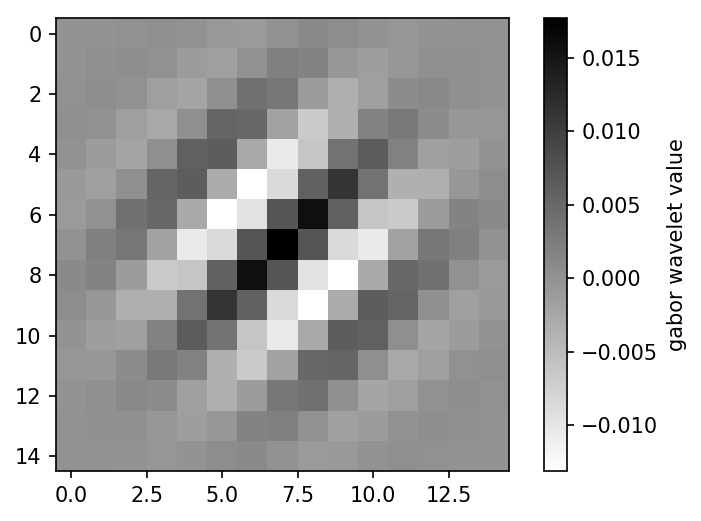

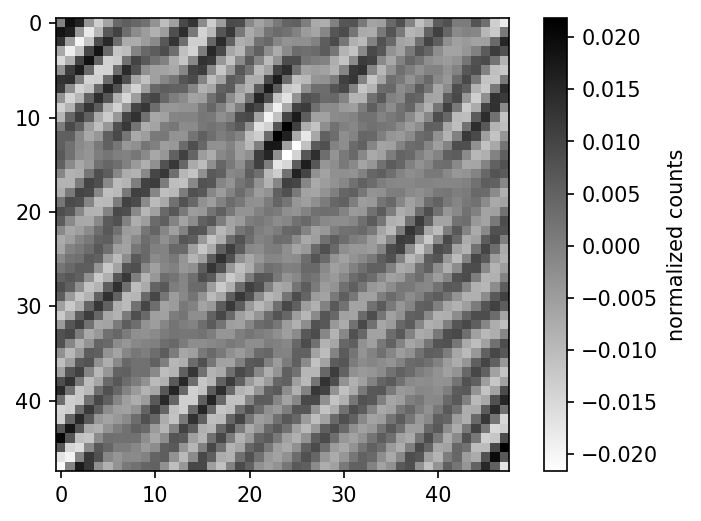

In [172]:
plt.close('all')
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.dpi'] = 150

# fig, ax = plt.subplots(1)
# cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 18), cmap='binary', vmin=0, vmax=6)
# fig.colorbar(cax, label="counts", ax=ax)

print(gabor_kernel_labels[16])

fig, ax = plt.subplots(1)
cax = ax.imshow(  gabor_kernels[16] , cmap='binary',) #
fig.colorbar(cax, label="gabor wavelet value", ax=ax)  

base_xy_proj_w_bg_max_norm_gabor = scipy.ndimage.convolve(base_xy_proj_w_bg_max_norm, gabor_kernels[16], mode='wrap')

print(base_xy_proj_w_bg_max_norm_gabor.mean(), base_xy_proj_w_bg_max_norm_gabor.var())

fig, ax = plt.subplots(1)
cax = ax.imshow(  base_xy_proj_w_bg_max_norm_gabor  , cmap='binary',) #
fig.colorbar(cax, label="normalized counts", ax=ax)  

plt.show()

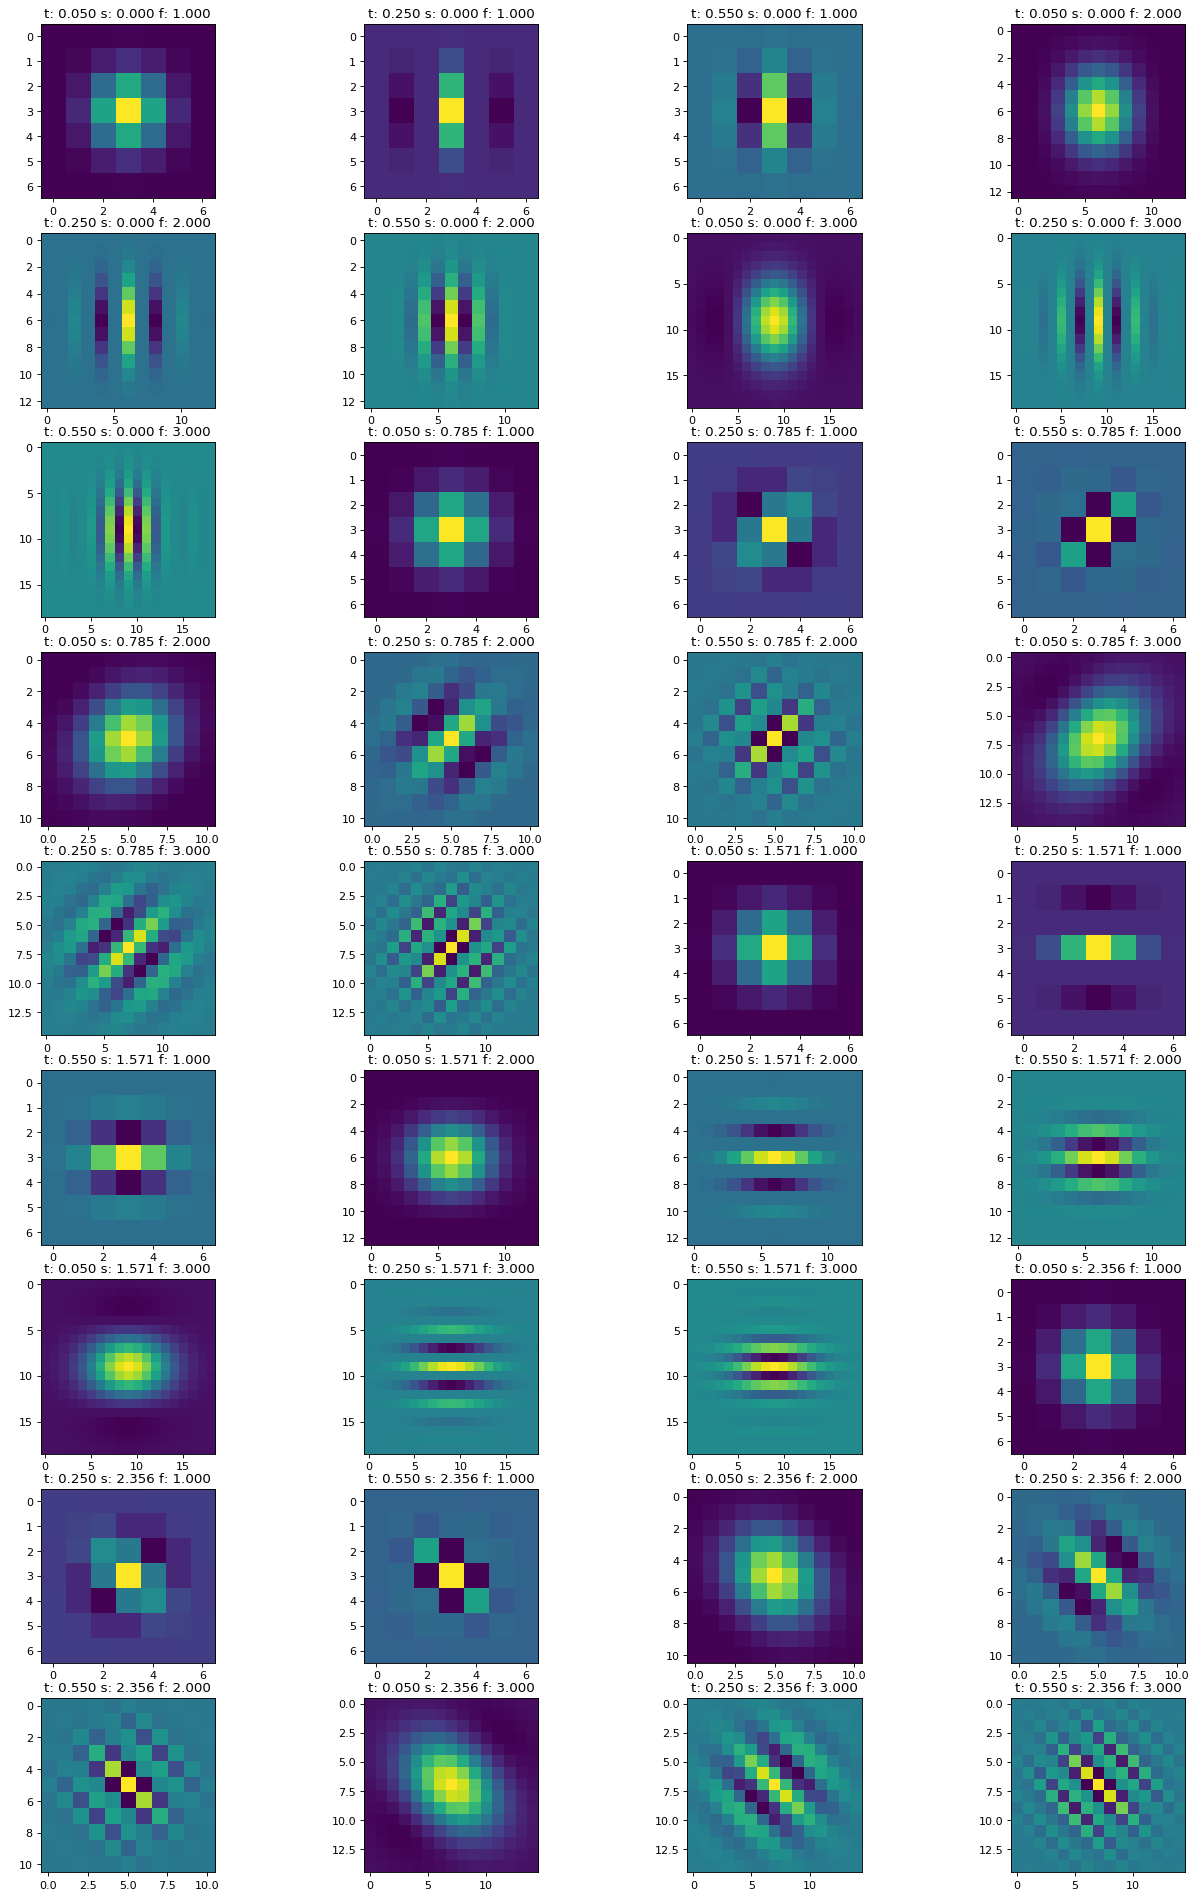

In [173]:
mpl.rcParams['figure.dpi'] = 80
vis_gabor_kernels(gabor_kernels, gabor_kernel_labels)
plt.show()

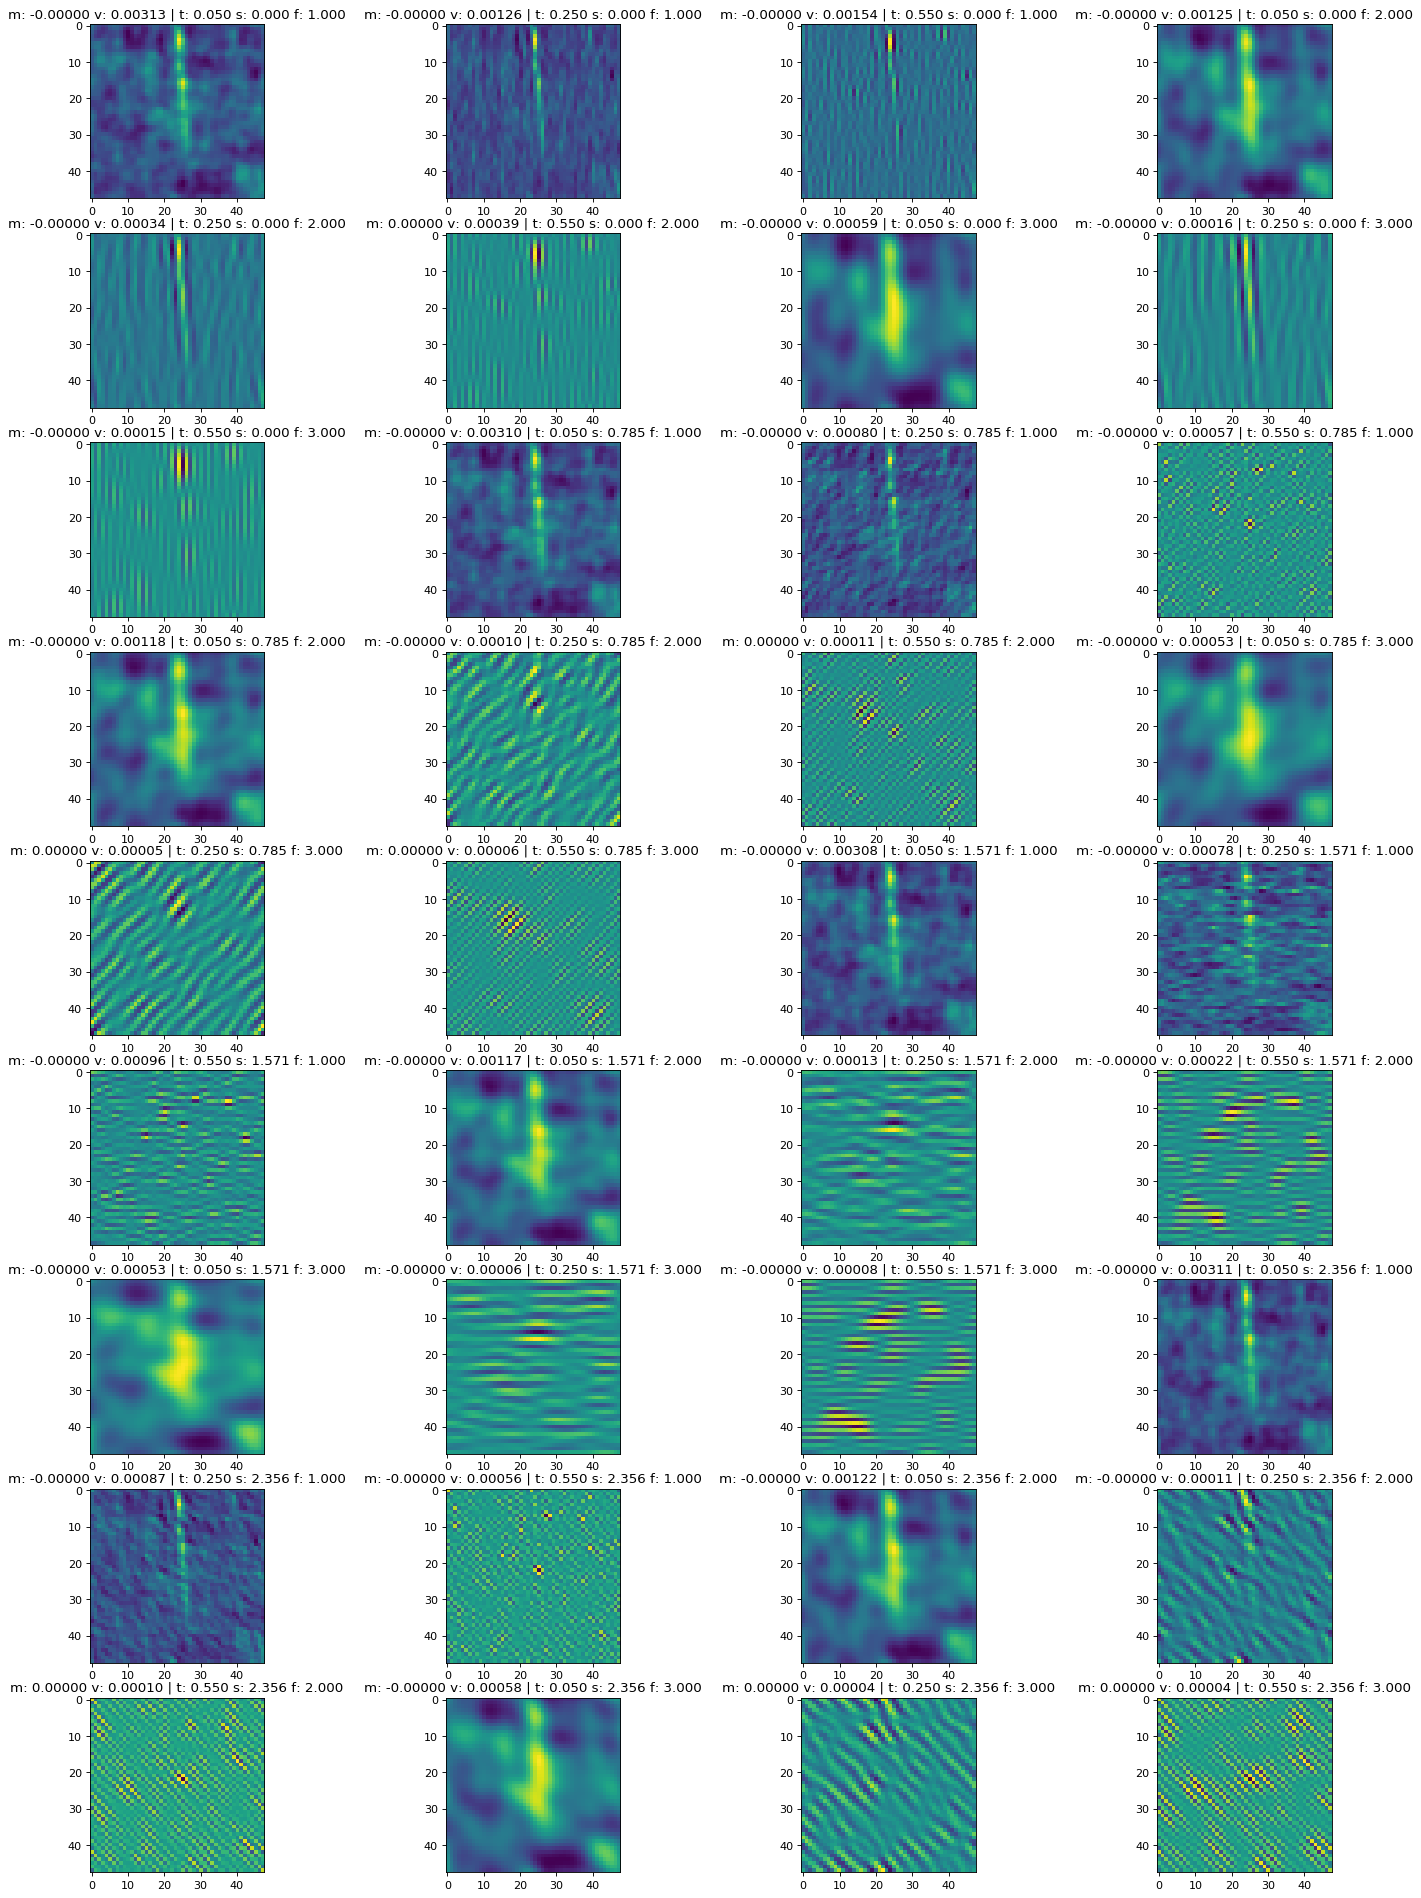

In [174]:
mpl.rcParams['figure.dpi'] = 80
vis_feats(base_xy_proj_w_bg_max_norm, gabor_kernels, gabor_kernel_labels) # base_xy_proj_n_bg_max_norm
plt.show()

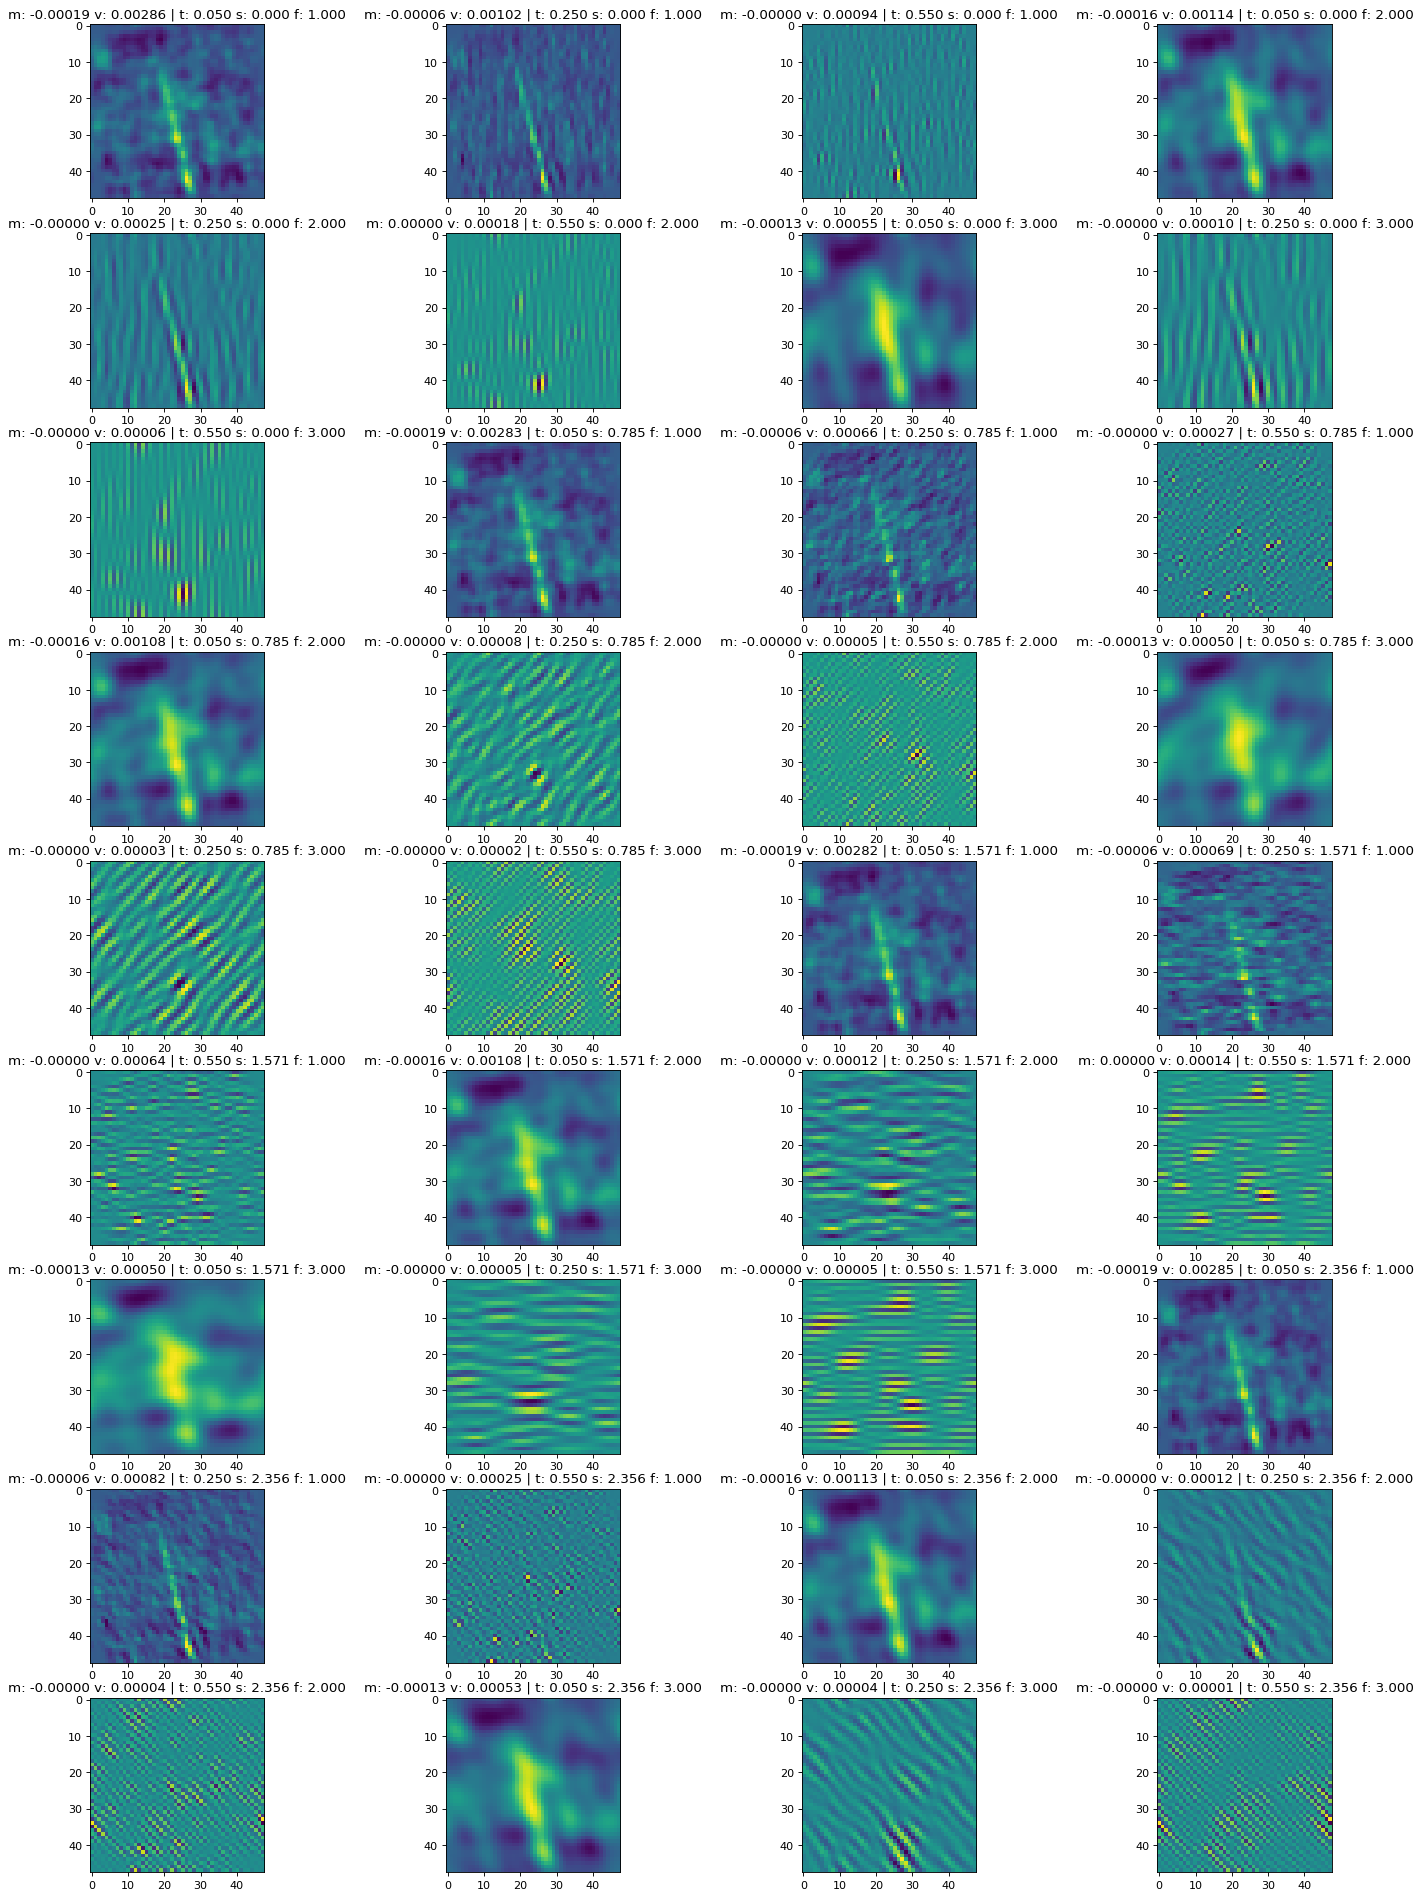

In [175]:
vis_feats( scipy.ndimage.rotate(base_xy_proj_w_bg_max_norm, angle=190, reshape=False), gabor_kernels, gabor_kernel_labels) # base_xy_proj_n_bg_max_norm
plt.show()

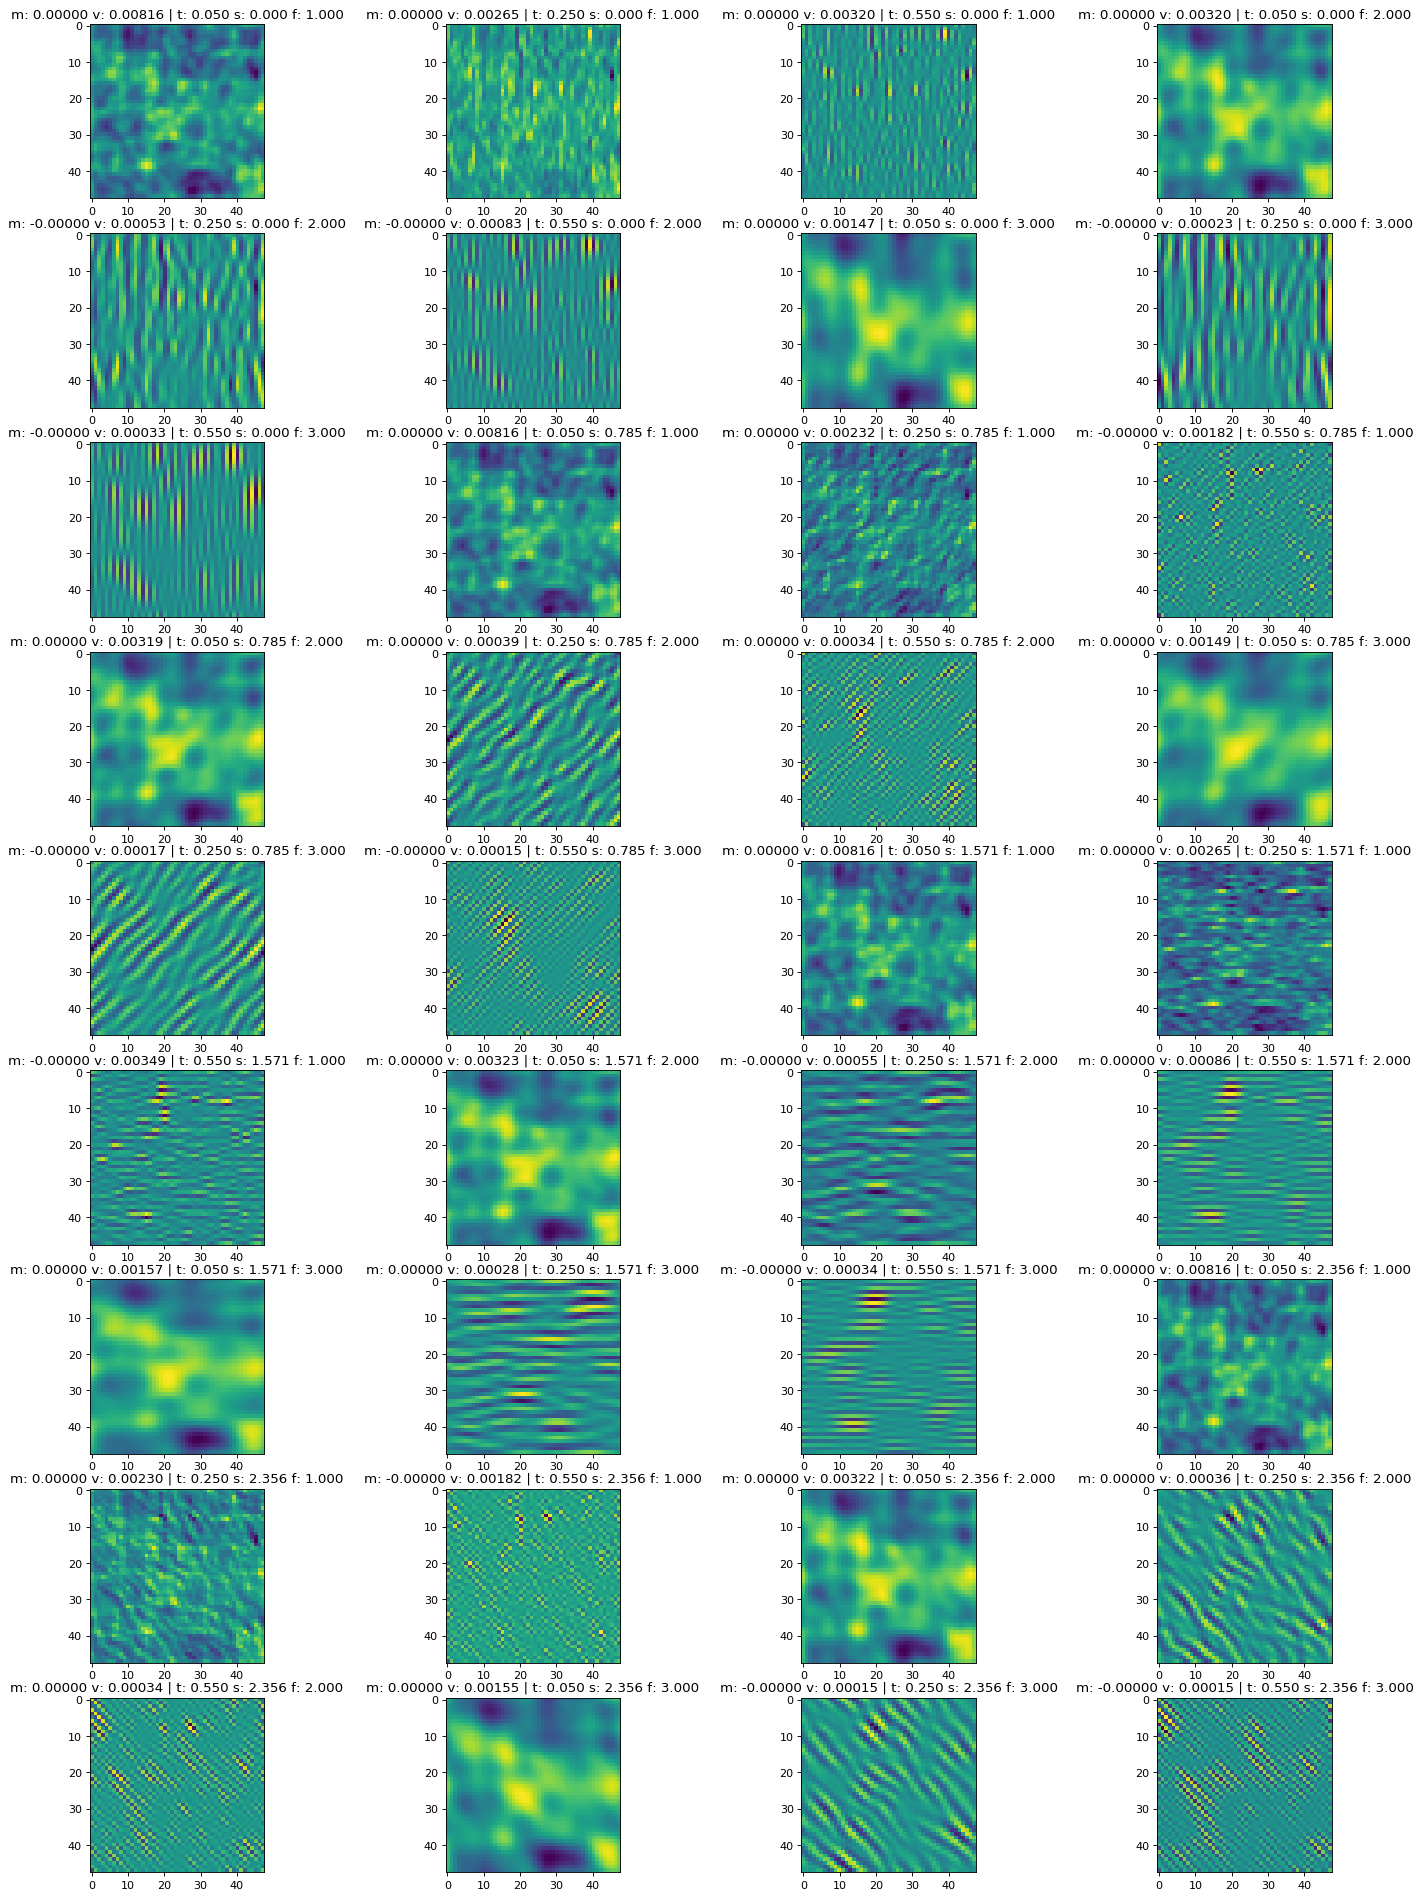

In [176]:
vis_feats(bg_xy_proj_cent_max_norm, gabor_kernels, gabor_kernel_labels) # base_xy_proj_n_bg_max_norm
plt.show()

In [177]:
ref_feats = np.zeros((2, len(gabor_kernels), 2), dtype=np.double)
ref_feats[1, :, :] = compute_feats(base_xy_proj_w_bg_max_norm, gabor_kernels)  # base_xy_proj_max_norm
ref_feats[0, :, :] = compute_feats(bg_xy_proj_cent_max_norm, gabor_kernels)

In [178]:
n2 = 42
# base_xy_proj_2 = xy_projections_bgsub[n2] * (xy_projections_bgsub[n2]>0)
base_xy_proj_2 = xy_projections[n2] * (xy_projections[n2]>0)

print("mean",  base_xy_proj_2.mean())

base_xy_proj_2_cent = (base_xy_proj_2 - base_xy_proj_2.mean() )

print('max(abs(cent))', np.max(np.abs(base_xy_proj_2_cent)))

base_xy_proj_2_max_norm = base_xy_proj_2_cent/np.max(np.abs(base_xy_proj_2_cent))
base_xy_proj_2_std_norm = base_xy_proj_2_cent/np.std(base_xy_proj_2_cent)

mean 2.91406
max(abs(cent)) 6.08594


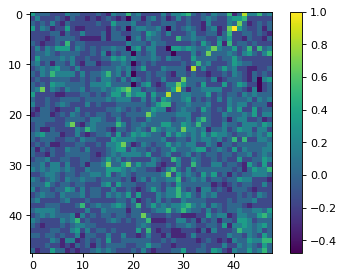

In [179]:
cax = plt.imshow(base_xy_proj_2_max_norm) # bg_xy_proj_cent_max_norm
plt.colorbar(cax)
plt.show()

In [180]:

feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=19, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=190, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=100, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=60, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
print("----------------------")
feats = compute_feats( bg_xy_proj_cent_max_norm, gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=19, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=190, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=100, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=60, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
# plt.show()
print("----------------------")
print("----------------------")
feats = compute_feats( base_xy_proj_2_max_norm, gabor_kernels) # base_xy_proj_n_bg_max_norm
vis_match(feats, ref_feats)

1
0 e: 0.00021 | m
1 e: 0.00001 | m
----------------------
1
0 e: 0.00021 | m
1 e: 0.00001 | m
----------------------
1
0 e: 0.00021 | m
1 e: 0.00001 | m
----------------------
1
0 e: 0.00022 | m
1 e: 0.00001 | m
----------------------
----------------------
0
0 e: 0.00000 | m
1 e: 0.00015
----------------------
0
0 e: 0.00003 | m
1 e: 0.00009
----------------------
0
0 e: 0.00003 | m
1 e: 0.00011
----------------------
0
0 e: 0.00003 | m
1 e: 0.00011
----------------------
0
0 e: 0.00003 | m
1 e: 0.00006
----------------------
----------------------
0 e: 0.00002 | m
1 e: 0.00005


0

In [181]:
n

1000

In [182]:
def classify_projections(xy_projections, exclude=[]):
    print("len(projections)", len(xy_projections))
    shower_classes = np.zeros(len(xy_projections)) # _bgsub
    for k, xy_projection in enumerate(xy_projections):
        if k in exclude: 
            continue
        c_xy_proj_w_bg = xy_projection * (xy_projection>0)
        c_xy_proj_w_bg_cent = (c_xy_proj_w_bg - c_xy_proj_w_bg.mean() )
        c_xy_proj_w_bg_max_norm = c_xy_proj_w_bg_cent/np.max(np.abs(c_xy_proj_w_bg_cent))
        feats = compute_feats(c_xy_proj_w_bg_max_norm, gabor_kernels)
        shower_classes[k] = match(feats, ref_feats)
        if k % 500 == 0:
            print(k)
    return shower_classes

In [183]:
visible_shower_classes = classify_projections(xy_projections, exclude=[n])
# np.zeros(len(xy_projections)) # _bgsub
# for k, xy_projection in enumerate(xy_projections):
#     if k == n: 
#         continue
#     c_xy_proj_w_bg = xy_projection * (xy_projection>0)
#     c_xy_proj_w_bg_cent = (c_xy_proj_w_bg - c_xy_proj_w_bg.mean() )
#     c_xy_proj_w_bg_max_norm = c_xy_proj_w_bg_cent/np.max(np.abs(c_xy_proj_w_bg_cent))
#     feats = compute_feats(c_xy_proj_w_bg_max_norm, gabor_kernels)
#     visible_shower_classes[k] = match(feats, ref_feats)
#     if k % 500 == 0:
#         print(k)

len(projections) 4011
0
500
1500
2000
2500
3000
3500
4000


In [184]:
print("num class 0:", len(visible_shower_classes) - np.count_nonzero(visible_shower_classes) )
print("num class 1:", np.count_nonzero(visible_shower_classes) )

num class 0: 234
num class 1: 3777


In [185]:
print("error: ",(len(visible_shower_classes) - np.count_nonzero(visible_shower_classes))/len(visible_shower_classes))
print("efficiency: ",np.count_nonzero(visible_shower_classes)/len(visible_shower_classes))

error:  0.05833956619296934
efficiency:  0.9416604338070307


In [186]:
less34_visible_shower_classes = classify_projections(less34_xy_projections, exclude=[])
print("num class 0:", len(less34_visible_shower_classes) - np.count_nonzero(less34_visible_shower_classes) )
print("num class 1:", np.count_nonzero(less34_visible_shower_classes) )

len(projections) 1124
0
500
1000
num class 0: 234
num class 1: 890


In [187]:
background_classes = classify_projections(background_xy_projections, exclude=[n])
# np.zeros(len(background_xy_projections))
# for k, xy_projection in enumerate(background_xy_projections):
#     if k == n: 
#         continue
#     c_xy_proj_w_bg = xy_projection * (xy_projection>0)
#     c_xy_proj_w_bg_cent = (c_xy_proj_w_bg - c_xy_proj_w_bg.mean() )
#     c_xy_proj_w_bg_max_norm = c_xy_proj_w_bg_cent/np.max(np.abs(c_xy_proj_w_bg_cent))
#     feats = compute_feats(c_xy_proj_w_bg_max_norm, gabor_kernels)
#     background_classes[k] = match(feats, ref_feats)
#     if k % 500 == 0:
#         print(k)
    
print("num class 0:", len(background_classes) - np.count_nonzero(background_classes) )
print("num class 1:", np.count_nonzero(background_classes) )

len(projections) 4011
0
500
1500
2000
2500
3000
3500
4000
num class 0: 2950
num class 1: 1061


In [188]:
less34_background_classes = classify_projections(less34_background_xy_projections, [])
print("num class 0:", len(less34_background_classes) - np.count_nonzero(less34_background_classes) )
print("num class 1:", np.count_nonzero(less34_background_classes) )

len(projections) 1124
0
500
1000
num class 0: 895
num class 1: 229


In [189]:
print("error: ",(np.count_nonzero(background_classes))/len(background_classes))
print("efficiency: ",(len(background_classes) - np.count_nonzero(background_classes))/len(background_classes))

error:  0.2645225629518823
efficiency:  0.7354774370481176


In [190]:
num_all_samples = len(visible_shower_classes)+len(background_classes)
num_all_samples_w_less34 = num_all_samples + len(less34_visible_shower_classes)+len(less34_background_classes)

num_valid_classifications = np.count_nonzero(visible_shower_classes) + (len(background_classes) - np.count_nonzero(background_classes))
num_valid_classifications_w_less34 = num_valid_classifications + np.count_nonzero(less34_visible_shower_classes) + (len(less34_background_classes) - np.count_nonzero(less34_background_classes))

# print("error: ",( np.count_nonzero(background_classes) + len(visible_shower_classes) - np.count_nonzero(visible_shower_classes))/(l)) 
print("efficiency: ",num_valid_classifications/num_all_samples )
print("efficiency with less34: ",num_valid_classifications_w_less34/num_all_samples_w_less34 )


efficiency:  0.8385689354275742
efficiency with less34:  0.8288218111002921


In [191]:
positive = len(visible_shower_classes)
negative = len(background_classes)
true_positive = np.count_nonzero(visible_shower_classes)
true_negative = (len(background_classes) - np.count_nonzero(background_classes))
false_negative = positive - true_positive
false_positive = negative - true_negative

# sensitivity, recall, hit rate, or true positive rate (TPR)
sensitivity = true_positive/positive  
# specificity or true negative rate (TNR)
specificity = true_negative/negative
# precision or positive predictive value (PPV)
precision = true_positive/(true_positive+false_positive)
# negative predictive value (NPV)
negative_predictive_value = true_negative/(true_negative+false_negative)
# miss rate or false negative rate (FNR)
miss_rate = false_negative/positive
# fall-out or false positive rate (FPR)
fall_out = false_positive/negative
# false discovery rate (FDR)
false_discovery_rate = false_positive / (false_positive+true_positive)
# false omission rate (FOR)
false_omission_rate = false_negative / (false_negative+true_negative)
# accuracy (ACC)
accuracy = (true_positive+true_negative)/(positive+negative)

print("positive:\t{}".format(positive))
print("negative:\t{}".format(negative))
print("true_positive:\t{}".format(true_positive))
print("true_negative:\t{}".format(true_negative))
print("false_positive:\t{}".format(false_positive))
print("false_negative:\t{}".format(false_negative))

print("sensitivity:\t{}".format(sensitivity))
print("specificity:\t{}".format(specificity))
print("precision:\t{}".format(precision))
print("negative_predictive_value:\t{}".format(negative_predictive_value))
print("miss_rate:\t{}".format(miss_rate))
print("fall_out:\t{}".format(fall_out))
print("false_discovery_rate:\t{}".format(false_discovery_rate))
print("false_omission_rate:\t{}".format(false_omission_rate))
print("accuracy:\t{}".format(accuracy))

positive:	4011
negative:	4011
true_positive:	3777
true_negative:	2950
false_positive:	1061
false_negative:	234
sensitivity:	0.9416604338070307
specificity:	0.7354774370481176
precision:	0.7806945018602729
negative_predictive_value:	0.9265075376884422
miss_rate:	0.05833956619296934
fall_out:	0.2645225629518823
false_discovery_rate:	0.21930549813972716
false_omission_rate:	0.07349246231155779
accuracy:	0.8385689354275742


In [192]:
visible_shower_classes

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [193]:
np.where(visible_shower_classes == 0)

(array([   7,   10,   12,   13,   19,   30,   32,   34,   39,   42,   48,
          50,   52,   54,   57,   65,   69,   70,   78,   80,   81,   88,
          93,  118,  119,  120,  122,  125,  126,  141,  142,  144,  145,
         147,  148,  157,  162,  170,  185,  199,  201,  204,  206,  208,
         212,  215,  218,  219,  229,  237,  247,  255,  260,  261,  275,
         281,  284,  285,  293,  302,  303,  306,  315,  320,  340,  352,
         357,  359,  361,  367,  368,  382,  384,  396,  401,  403,  416,
         421,  425,  426,  433,  437,  443,  444,  455,  465,  468,  471,
         473,  477,  482,  483,  484,  486,  501,  503,  504,  532,  537,
         548,  551,  561,  569,  573,  576,  593,  599,  612,  615,  618,
         637,  648,  649,  651,  652,  664,  666,  725,  736,  746,  747,
         756,  759,  781,  782,  790,  798,  822,  836,  844,  860,  862,
         863,  864,  865,  866,  873,  910,  912,  949,  958,  965,  978,
        1000, 1014, 1020, 1027, 1028, 

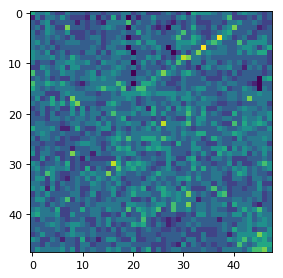

In [194]:
plt.imshow(xy_projections[7])
plt.show()

In [195]:
np.where(background_classes == 1)[0][0:30]

array([  7,   9,  13,  16,  21,  23,  35,  44,  45,  59,  61,  62,  63,
        68,  69,  72,  79,  92,  95,  97,  98, 100, 103, 106, 107, 109,
       110, 114, 115, 116])

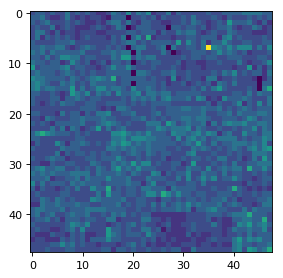

In [196]:
plt.imshow(background_xy_projections[59])
plt.show()

In [197]:
print(np.where(visible_shower_classes == 0))
print(np.where(less34_visible_shower_classes == 0))

(array([   7,   10,   12,   13,   19,   30,   32,   34,   39,   42,   48,
         50,   52,   54,   57,   65,   69,   70,   78,   80,   81,   88,
         93,  118,  119,  120,  122,  125,  126,  141,  142,  144,  145,
        147,  148,  157,  162,  170,  185,  199,  201,  204,  206,  208,
        212,  215,  218,  219,  229,  237,  247,  255,  260,  261,  275,
        281,  284,  285,  293,  302,  303,  306,  315,  320,  340,  352,
        357,  359,  361,  367,  368,  382,  384,  396,  401,  403,  416,
        421,  425,  426,  433,  437,  443,  444,  455,  465,  468,  471,
        473,  477,  482,  483,  484,  486,  501,  503,  504,  532,  537,
        548,  551,  561,  569,  573,  576,  593,  599,  612,  615,  618,
        637,  648,  649,  651,  652,  664,  666,  725,  736,  746,  747,
        756,  759,  781,  782,  790,  798,  822,  836,  844,  860,  862,
        863,  864,  865,  866,  873,  910,  912,  949,  958,  965,  978,
       1000, 1014, 1020, 1027, 1028, 1035, 1051, 1